# Notebook 3: Pipeline Completo de Ciencia de Datos

Este notebook demuestra el pipeline completo del proyecto, utilizando todos los módulos de `src` para ejecutar una metodología de ciencia de datos de principio a fin:

1. **Análisis Exploratorio de Datos (EDA)**
2. **Preprocesamiento y Construcción de Características**
3. **Selección de Características**
4. **Comparación de Modelos con Grid Search y Curvas de Aprendizaje**
5. **Evaluación Robusta del Mejor Modelo (Nested CV)**
6. **Interpretabilidad del Modelo**

In [1]:
import sys, os, pandas as pd, numpy as np, joblib, matplotlib.pyplot as plt, seaborn as sns, time
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# --- Módulos del proyecto ---
from data.loader import cargar_csv_crudo
from eda.eda_report import tabla_nulos, balance_clases
from features.build_features import crear_ratios_financieros
from features.transformers_manual import ImputadorNumericoMediana, ImputadorCategoricoModa, EscaladorEstandarManual, OneHotManual
from features.selection_manual import SelectKBestManual, anova_f_score_manual
from models.algorithms_manual import RegresionLogisticaManual, RandomForestManual, SVMManual
from models.knn_wrapper import crear_pipeline_knn
from evaluation.cv_manual import StratifiedKFoldManual, grid_search_manual, nested_cv_manual
from evaluation.metrics_manual import matriz_confusion_manual, balanced_accuracy_manual, precision_recall_f1_por_clase, macro_f1_score, roc_auc_manual, pr_auc_manual
from evaluation.metrics import classification_report,cost_sensitive_evaluation
from interpretability.shap_like_manual import importancia_features_global, graficar_pdp_manual,calcular_importancia_modelo,analizar_importancia_inteligente

## Funciones Auxiliares de Visualización

In [2]:
def graficar_matriz_confusion(matriz_conf, etiquetas_clases, nombre_modelo):
    matriz_normalizada = matriz_conf.astype('float') / matriz_conf.sum(axis=1)[:, np.newaxis]
    matriz_normalizada = np.nan_to_num(matriz_normalizada)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matriz_normalizada, annot=True, fmt='.2f', cmap='Blues', xticklabels=etiquetas_clases, yticklabels=etiquetas_clases)
    plt.title(f'Matriz de Confusión Normalizada para {nombre_modelo}')
    plt.ylabel('Etiqueta Verdadera'); plt.xlabel('Etiqueta Predicha'); plt.show()

def graficar_curvas_costo(historial, nombre_modelo):
    if isinstance(historial, dict) and 'entrenamiento' not in historial:
        hist_ent = np.mean([h['entrenamiento'] for h in historial.values()], axis=0)
        hist_val = np.mean([h['validacion'] for h in historial.values()], axis=0)
    else:
        hist_ent = historial.get('entrenamiento', []); hist_val = historial.get('validacion', [])
    
    if not hist_ent or not hist_val: return
    plt.figure(figsize=(10, 6))
    plt.plot(hist_ent, label='Costo de Entrenamiento'); plt.plot(hist_val, label='Costo de Validación')
    plt.title(f'Curvas de Aprendizaje (Costo) para {nombre_modelo}'); plt.xlabel('Épocas'); plt.ylabel('Costo'); plt.legend(); plt.grid(True); plt.show()

## 1. Pipeline de Preprocesamiento y Selección

In [3]:
df_train = cargar_csv_crudo('datos_entrenamiento_riesgo.csv')
df_test = cargar_csv_crudo('datos_prueba_riesgo.csv')

# Crear ratios financieros
df_train = crear_ratios_financieros(df_train)
df_test = crear_ratios_financieros(df_test)

# Separar features y target
X_train_raw = df_train.drop('nivel_riesgo', axis=1)
y_train = df_train['nivel_riesgo'].map({'Bajo': 0, 'Medio': 1, 'Alto': 2}).values

X_test_raw = df_test.drop('nivel_riesgo', axis=1)
y_test = df_test['nivel_riesgo'].map({'Bajo': 0, 'Medio': 1, 'Alto': 2}).values

# Identificar columnas numéricas y categóricas
num_cols = X_train_raw.select_dtypes(include=np.number).columns.tolist()  # <-- convertir a lista
cat_cols = X_train_raw.select_dtypes(include='object').columns.tolist()  # <-- convertir a lista

# Imputación numérica
imputador_num = ImputadorNumericoMediana(variables=num_cols).fit(X_train_raw)
X_train_imp = imputador_num.transform(X_train_raw)
X_test_imp = imputador_num.transform(X_test_raw)

# Imputación categórica
imputador_cat = ImputadorCategoricoModa(variables=cat_cols).fit(X_train_imp)
X_train_imp = imputador_cat.transform(X_train_imp)
X_test_imp = imputador_cat.transform(X_test_imp)

# One-hot encoding
onehot = OneHotManual(variables=cat_cols, drop_last=True).fit(X_train_imp)
X_train_oh = onehot.transform(X_train_imp)
X_test_oh = onehot.transform(X_test_imp)

# Alinear columnas de test con train
train_cols, test_cols = set(X_train_oh.columns), set(X_test_oh.columns)
for col in (train_cols - test_cols):
    X_test_oh[col] = 0
X_test_oh = X_test_oh[X_train_oh.columns]

# Selección de características
selector = SelectKBestManual(score_func=anova_f_score_manual, k=20).fit(X_train_oh, pd.Series(y_train))
X_train_sel = selector.transform(X_train_oh)
X_test_sel = selector.transform(X_test_oh)
features_seleccionadas = X_train_sel.columns.tolist()

# Escalado
escalador = EscaladorEstandarManual().fit(X_train_sel)
X_train = escalador.transform(X_train_sel).values
X_test = escalador.transform(X_test_sel).values

Cargando datos desde: e:\06. Sexto Ciclo\01. Machine Learning\07. Workspace\06S03. Proyecto 01\06C_Machine_06S01_Clasification\data\raw\datos_entrenamiento_riesgo.csv
Cargando datos desde: e:\06. Sexto Ciclo\01. Machine Learning\07. Workspace\06S03. Proyecto 01\06C_Machine_06S01_Clasification\data\raw\datos_prueba_riesgo.csv
Creando ratios financieros...
Creando ratios financieros...


## 2. Comparación de Modelos

In [4]:
modelos_a_probar = {
    'RegresionLogistica': {'clase': RegresionLogisticaManual, 'rejilla': {'tasa_aprendizaje': [0.1, 0.05, 0.01, 0.005, 0.001], 'C': [0.1, 1, 10, 100], 'epocas': [500]}, 'calibrar': False, 'iterativo': True},
    #'RegresionLogistica': {'clase': RegresionLogisticaManual, 'rejilla': {'tasa_aprendizaje': [0.1], 'C': [0.1], 'epocas': [500]}, 'calibrar': False, 'iterativo': True},
    'KNN': {'clase': lambda **kwargs: crear_pipeline_knn(**kwargs), 'rejilla': {'n_neighbors': [3,5,7,9,11,15,21], 'metric': ['euclidean','manhattan','chebyshev'], 'weights': ['uniform','distance']}, 'calibrar': False, 'iterativo': False},
    #'KNN': {'clase': lambda **kwargs: crear_pipeline_knn(**kwargs), 'rejilla': {'n_neighbors': [3], 'metric': ['chebyshev'], 'weights': ['uniform','distance']}, 'calibrar': False, 'iterativo': False}
    'SVM': {'clase': SVMManual, 'rejilla': {'tasa_aprendizaje': [0.01, 0.001, 0.0005], 'C': [1, 10, 100], 'epocas': [300, 500]}, 'calibrar': True, 'iterativo': True},
    'RandomForest': {'clase': RandomForestManual, 'rejilla': {'n_estimadores': [100, 200], 'max_profundidad': [10, 15, 20]}, 'calibrar': False, 'iterativo': False}
}
resultados_finales = {}; modelos_entrenados = {}


==================== PROCESANDO MODELO: RegresionLogistica ====================
Iniciando Grid Search manual...
Probando combinación 1/20: {'tasa_aprendizaje': 0.1, 'C': 0.1, 'epocas': 500}
  Score promedio de CV: 0.3333
Probando combinación 2/20: {'tasa_aprendizaje': 0.1, 'C': 1, 'epocas': 500}
  Score promedio de CV: 0.3684
Probando combinación 3/20: {'tasa_aprendizaje': 0.1, 'C': 10, 'epocas': 500}
  Score promedio de CV: 0.6563
Probando combinación 4/20: {'tasa_aprendizaje': 0.1, 'C': 100, 'epocas': 500}
  Score promedio de CV: 0.8862
Probando combinación 5/20: {'tasa_aprendizaje': 0.05, 'C': 0.1, 'epocas': 500}
  Score promedio de CV: 0.3333
Probando combinación 6/20: {'tasa_aprendizaje': 0.05, 'C': 1, 'epocas': 500}
  Score promedio de CV: 0.3682
Probando combinación 7/20: {'tasa_aprendizaje': 0.05, 'C': 10, 'epocas': 500}
  Score promedio de CV: 0.6514
Probando combinación 8/20: {'tasa_aprendizaje': 0.05, 'C': 100, 'epocas': 500}
  Score promedio de CV: 0.8485
Probando combinac

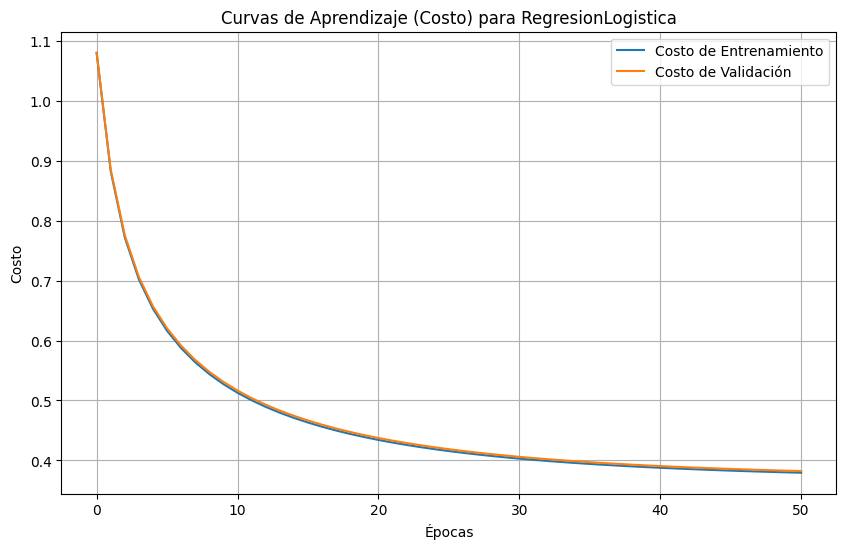


--- Métricas detalladas por Clase para RegresionLogistica ---


,precision,recall,f1_score
Bajo,1.000000,0.952350,0.975593
Medio,0.905267,1.000000,0.950278
Alto,1.000000,0.710204,0.830549


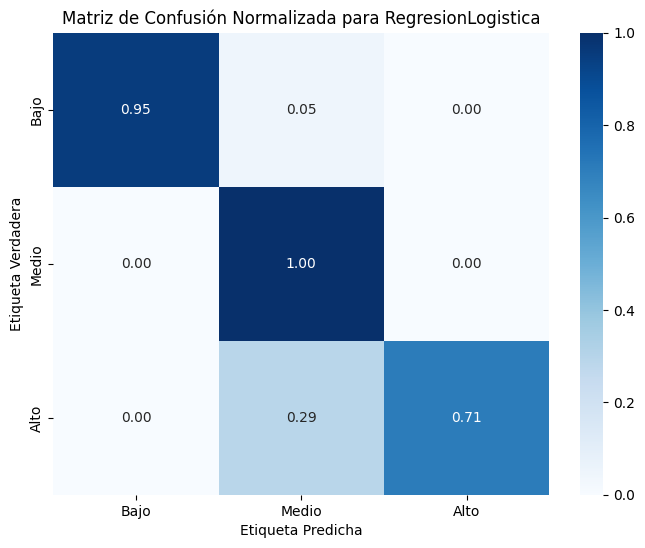


--- Resumen rápido de RegresionLogistica ---
Accuracy: 0.9428
F1-Score (Macro): 0.9188
AUC-ROC (Macro): 0.9990

==================== PROCESANDO MODELO: KNN ====================
Iniciando Grid Search manual...
Probando combinación 1/42: {'n_neighbors': 3, 'metric': 'euclidean', 'weights': 'uniform'}
  Score promedio de CV: 0.6617
Probando combinación 2/42: {'n_neighbors': 3, 'metric': 'euclidean', 'weights': 'distance'}
  Score promedio de CV: 0.6678
Probando combinación 3/42: {'n_neighbors': 3, 'metric': 'manhattan', 'weights': 'uniform'}
  Score promedio de CV: 0.6524
Probando combinación 4/42: {'n_neighbors': 3, 'metric': 'manhattan', 'weights': 'distance'}
  Score promedio de CV: 0.6602
Probando combinación 5/42: {'n_neighbors': 3, 'metric': 'chebyshev', 'weights': 'uniform'}
  Score promedio de CV: 0.5802
Probando combinación 6/42: {'n_neighbors': 3, 'metric': 'chebyshev', 'weights': 'distance'}
  Score promedio de CV: 0.5891
Probando combinación 7/42: {'n_neighbors': 5, 'metric':

,precision,recall,f1_score
Bajo,0.891785,0.736945,0.807005
Medio,0.755680,0.937065,0.836655
Alto,0.898551,0.421769,0.574074


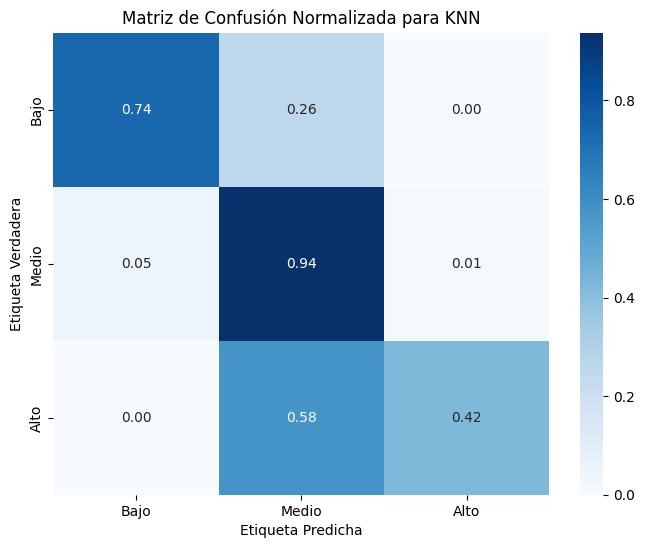


--- Resumen rápido de KNN ---
Accuracy: 0.8000
F1-Score (Macro): 0.7392
AUC-ROC (Macro): 0.9283

==================== PROCESANDO MODELO: SVM ====================
Iniciando Grid Search manual...
Probando combinación 1/18: {'tasa_aprendizaje': 0.01, 'C': 1, 'epocas': 300}
  Score promedio de CV: 0.3335
Probando combinación 2/18: {'tasa_aprendizaje': 0.01, 'C': 1, 'epocas': 500}
  Score promedio de CV: 0.3335
Probando combinación 3/18: {'tasa_aprendizaje': 0.01, 'C': 10, 'epocas': 300}
  Score promedio de CV: 0.5837
Probando combinación 4/18: {'tasa_aprendizaje': 0.01, 'C': 10, 'epocas': 500}
  Score promedio de CV: 0.5826
Probando combinación 5/18: {'tasa_aprendizaje': 0.01, 'C': 100, 'epocas': 300}
  Score promedio de CV: 0.6739
Probando combinación 6/18: {'tasa_aprendizaje': 0.01, 'C': 100, 'epocas': 500}


In [ ]:
resultados_finales = {}

for nombre_modelo, config in modelos_a_probar.items():
    print(f"\n{'='*20} PROCESANDO MODELO: {nombre_modelo} {'='*20}")
    
    # Grid Search manual
    mejores_params, _ = grid_search_manual(config['clase'], config['rejilla'], X_train, y_train,
                                           StratifiedKFoldManual(n_splits=3, random_state=42))
    
    # Inicializar modelo final con los mejores parámetros
    modelo_final = config['clase'](**mejores_params)
    
    # Entrenamiento iterativo si aplica
    if config['iterativo']:
        X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
        modelo_final.fit(X_t, y_t, X_val=X_v, y_val=y_v)
        graficar_curvas_costo(modelo_final.historial_costo_, nombre_modelo)
    
    # Reentrenamiento con todos los datos
    modelo_final.fit(X_train, y_train)
    modelos_entrenados[nombre_modelo] = modelo_final
    
    # Predicción y calibración si aplica
    if config['calibrar']:
        calibrador = RegresionLogisticaManual(epocas=100).fit(modelo_final.predict_scores(X_train), y_train)
        y_pred_proba = calibrador.predict_proba(modelo_final.predict_scores(X_test))
    else:
        y_pred_proba = modelo_final.predict_proba(X_test)
    
    y_pred = np.argmax(y_pred_proba, axis=1)
    etiquetas = ['Bajo', 'Medio', 'Alto']
    
    # Matriz de confusión y métricas por clase
    matriz_conf, _ = matriz_confusion_manual(y_test, y_pred, etiquetas=[0, 1, 2])
    metricas_clase = precision_recall_f1_por_clase(matriz_conf)
    
    print(f"\n--- Métricas detalladas por Clase para {nombre_modelo} ---")
    df_metricas = pd.DataFrame(metricas_clase).T
    df_metricas.index = etiquetas
    display(df_metricas)
    
    graficar_matriz_confusion(matriz_conf, etiquetas, nombre_modelo)
    
    # Evaluación completa
    report = classification_report(y_test, y_pred, class_names=etiquetas)
    cost_eval = cost_sensitive_evaluation(y_test, y_pred)
    
    # Guardar resultados resumidos
    resultados_finales[nombre_modelo] = {
        'Accuracy': report['accuracy'],
        'Precision (Macro)': report['macro_avg']['precision'],
        'Recall (Macro)': report['macro_avg']['recall'],
        'F1-Score (Macro)': report['macro_avg']['f1_score'],
        'Precision (Micro)': report['micro_avg']['precision'],
        'Recall (Micro)': report['micro_avg']['recall'],
        'F1-Score (Micro)': report['micro_avg']['f1_score'],
        'Support Bajo': report['per_class']['support'][0],
        'Support Medio': report['per_class']['support'][1],
        'Support Alto': report['per_class']['support'][2],
        'Balanced Accuracy': balanced_accuracy_manual(matriz_conf),
        'Macro F1-Score': macro_f1_score(metricas_clase),
        'AUC-ROC (Macro)': roc_auc_manual(y_test, y_pred_proba),
        'Average Cost': cost_eval['average_cost'],
        'Total Cost': cost_eval['total_cost']
    }
    
    # Mostrar resumen rápido intermedio
    print(f"\n--- Resumen rápido de {nombre_modelo} ---")
    resumen_rapido = {k: resultados_finales[nombre_modelo][k] for k in ['Accuracy', 'F1-Score (Macro)', 'AUC-ROC (Macro)']}
    for k, v in resumen_rapido.items():
        print(f"{k}: {v:.4f}")

# DataFrame comparativo final
df_resultados = pd.DataFrame(resultados_finales).T
df_resultados.index.name = 'Modelo'

print("\n" + "="*50 + "\nTABLA COMPARATIVA FINAL DE MODELOS\n" + "="*50)
display(df_resultados.style.background_gradient(cmap='viridis', axis=0))


## 3. Interpretabilidad del Mejor Modelo

Analizando el mejor modelo: RegresionLogistica
🔍 Detectando tipo de modelo...
🎯 Tipo de modelo: RegresionLogisticaManual
🔧 Modelo con posible importancia global - intentando...
✅ Importancia global calculada exitosamente


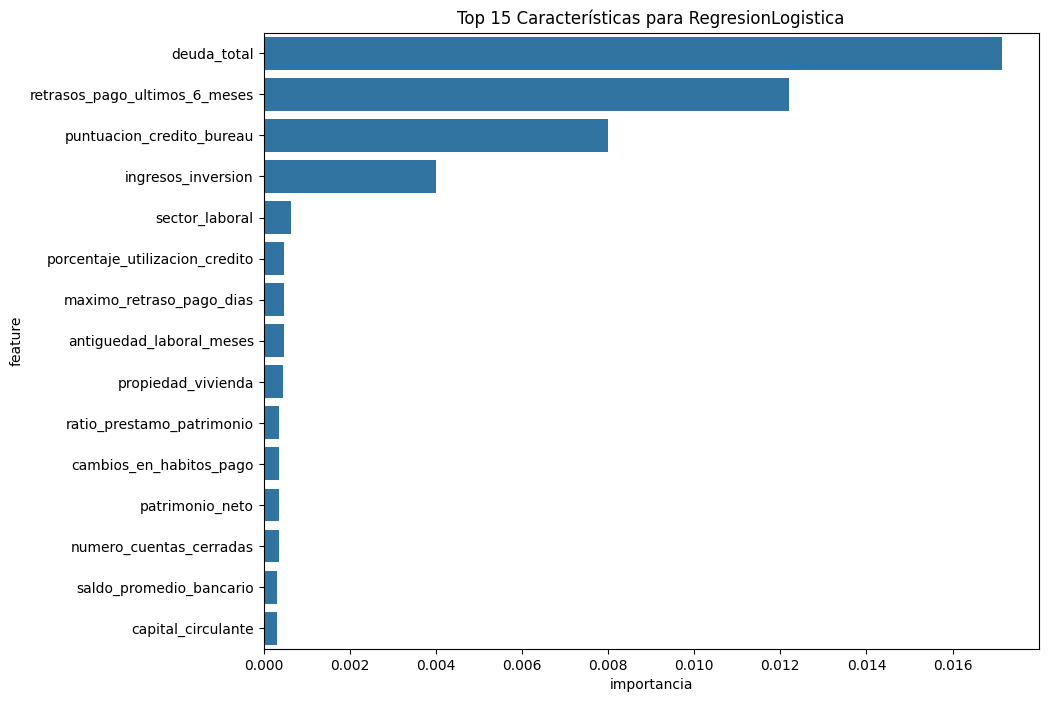

In [ ]:
mejor_modelo_nombre = df_resultados['Macro F1-Score'].idxmax()
mejor_modelo_final = modelos_entrenados[mejor_modelo_nombre]
print(f"Analizando el mejor modelo: {mejor_modelo_nombre}")

df_importancia = analizar_importancia_inteligente(mejor_modelo_final, features_seleccionadas,X_val=X_test_sel,y_val=y_test,n_repeticiones=5)
plt.figure(figsize=(10, 8)); sns.barplot(x='importancia', y='feature', data=df_importancia.head(15)); plt.title(f'Top 15 Características para {mejor_modelo_nombre}'); plt.show()